In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
import time
from tqdm import tqdm
from path_explain.path_explainer_tf import PathExplainerTF

In [4]:
baseline = np.random.randn(1000, 10)
inputs = np.random.randn(50, 10)

In [5]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(10, dtype=tf.float32))
model.add(tf.keras.layers.Dense(5, activation=tf.keras.activations.softplus, use_bias=True))
model.add(tf.keras.layers.Dense(1, activation=None, use_bias=False))

In [6]:
explainer = PathExplainerTF(model)

In [7]:
current_alphas = explainer._sample_alphas(num_samples=100, use_expectation=True, use_product=True)
interactions = explainer._single_interaction(inputs[0], baseline,
                              current_alphas, num_samples=100, batch_size=50,
                              use_expectation=True, output_index=None,
                              interaction_index=None)
assert interactions.shape == (10, 10)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



## Testing Shape
We need to make sure our attributions return an array of the right shape.

In [8]:
interactions = explainer.interactions(inputs, baseline,
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(inputs),
                     verbose=True, interaction_index=0)
assert interactions.shape == (50, 10)

100%|██████████| 50/50 [00:00<00:00, 82.79it/s]


In [9]:
(model(inputs) - np.mean(model(baseline)))[:, 0]

<tf.Tensor: id=4626, shape=(50,), dtype=float32, numpy=
array([-1.3427489 , -0.33881783,  0.47907317, -0.6838472 ,  0.5334646 ,
        0.0947026 ,  0.07244134,  0.05426681,  0.9103896 ,  0.52255446,
       -1.0420234 ,  0.5211824 ,  0.7900971 ,  0.782961  ,  0.10859323,
       -0.48043275,  0.1023401 , -0.19518757,  0.8270062 ,  0.02378452,
        0.31242394,  0.31487918,  0.19367504, -0.28967178, -0.10209334,
        0.6361164 ,  0.32415974, -0.43430793,  1.0954902 ,  0.26595116,
        0.5102163 ,  0.7160038 ,  0.30422628,  0.5931645 , -0.22245598,
       -0.838125  ,  0.4574905 , -0.15941143,  1.1450742 ,  0.6430816 ,
        0.15012693, -0.35090804, -0.04101181, -0.01166427,  0.10673785,
        0.2920891 , -0.8904693 , -1.2972481 ,  0.3623668 ,  1.074553  ],
      dtype=float32)>

In [10]:
interactions = explainer.interactions(inputs, baseline,
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(inputs),
                     verbose=True, interaction_index=None)
assert interactions.shape == (50, 10, 10)

100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


In [11]:
np.sum(interactions, axis=(1,2))

array([-1.30872566, -0.32256069,  0.43377426, -0.75540004,  0.41350053,
        0.01103091,  0.0661293 , -0.07516162,  0.80630199,  0.41561447,
       -1.15160142,  0.43081334,  0.75152945,  0.66253431,  0.15453918,
       -0.75472854,  0.14444752, -0.21960029,  0.82188323,  0.04905743,
        0.23490913,  0.45187604,  0.20404591, -0.2645939 , -0.25883757,
        0.72599303,  0.35901734, -0.32999748,  1.14348936,  0.24453223,
        0.40369636,  0.69023902,  0.28844417,  0.69415201, -0.3328863 ,
       -0.6748481 ,  0.45444499, -0.24137996,  1.16215325,  0.79544436,
        0.07757725, -0.35041084, -0.04899226, -0.08006231,  0.07599735,
        0.3329452 , -0.86738011, -1.26143515,  0.26660627,  1.01751743])

## Testing completeness
We need to make sure our interactions satisfy completeness!

In [35]:
interactions = explainer.interactions(inputs, baseline,
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(inputs),
                     verbose=True, interaction_index=None)

100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


In [37]:
attributions = explainer.attributions(inputs, baseline,
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(inputs),
                     verbose=True)

100%|██████████| 50/50 [00:00<00:00, 150.63it/s]


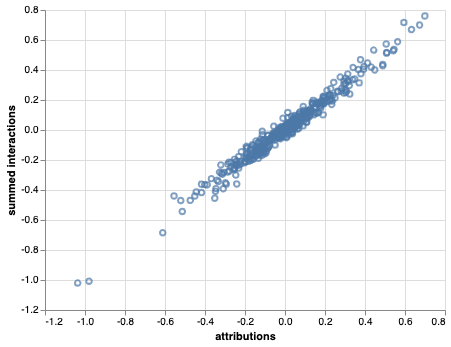

In [38]:
summed_interactions = np.sum(interactions, axis=1)
data_df = pd.DataFrame({
    'attributions': attributions.flatten(),
    'summed interactions': summed_interactions.flatten()
})
alt.Chart(data_df).mark_point().encode(
    alt.X('attributions:Q'),
    alt.Y('summed interactions:Q')
)

In [10]:
batch_sizes = np.linspace(10, 200, 20).astype(int)
times = []
for batch_size in tqdm(batch_sizes):
    start_time = time.time()
    interactions = explainer.interactions(inputs, baseline,
                     batch_size=batch_size, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(inputs),
                     verbose=False, interaction_index=None)
    end_time = time.time()
    times.append(end_time - start_time)
    assert interactions.shape == (50, 10, 10), 'batch_size: {}'.format(batch_size)

100%|██████████| 20/20 [01:47<00:00,  5.36s/it]


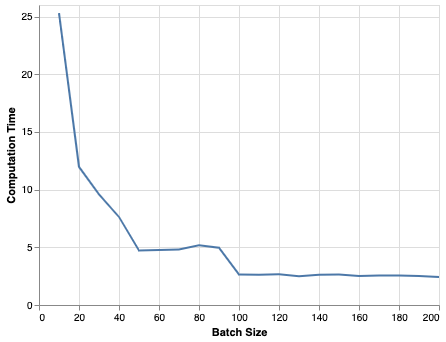

In [11]:
time_df = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Computation Time': times
})
alt.Chart(time_df).mark_line().encode(
    alt.X('Batch Size:Q'),
    alt.Y('Computation Time:Q')
)